In [1]:
import os
import glob

import cv2
from PIL import Image
import numpy as np
import pandas as pd


import pywt
import matplotlib.pyplot as plt

In [2]:
# load image as PIL image
img_array = cv2.imread(glob.glob(f'{os.getcwd()}/data/run1/00001.bmp')[0])
img_array = img_array[...,::-1] # for correct color

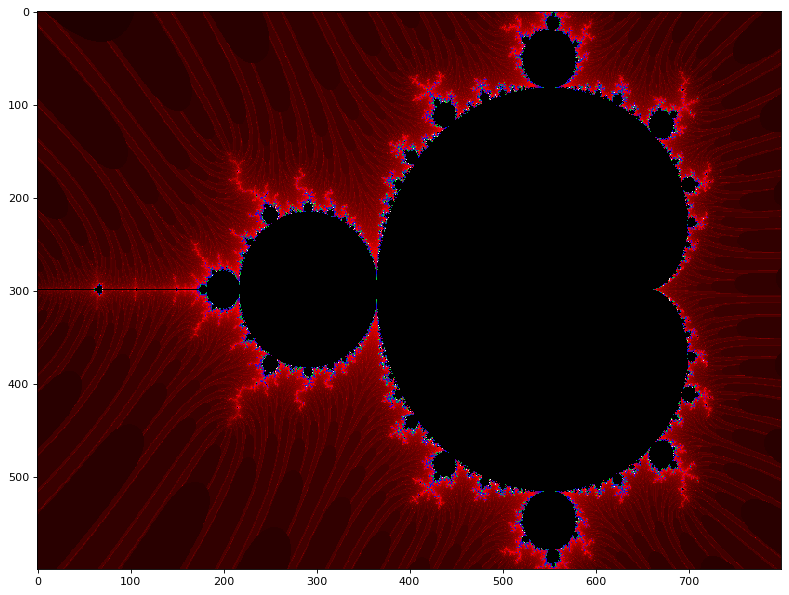

In [3]:
fig = plt.figure(figsize=(12, 12), dpi=80)
plt.imshow(img_array, interpolation='nearest')

fig.savefig('original.png', dpi=300)

In [4]:
# convert to gray scale image 
img_array_gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

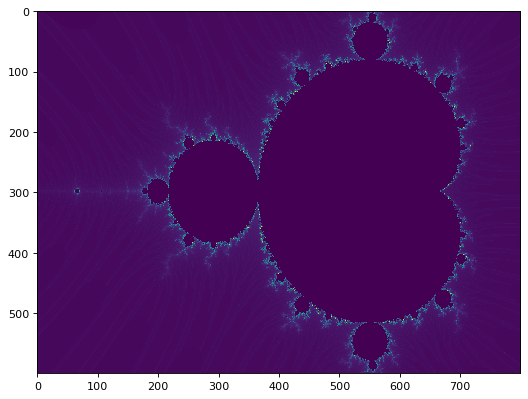

In [5]:
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(img_array_gray, interpolation='nearest')

fig.savefig('original.png', dpi=300)

In [6]:
coeffs = pywt.dwt2(img_array_gray, 'bior1.3')

In [7]:
LL, (LH, HL, HH) = coeffs

In [8]:
HH = abs(HH)

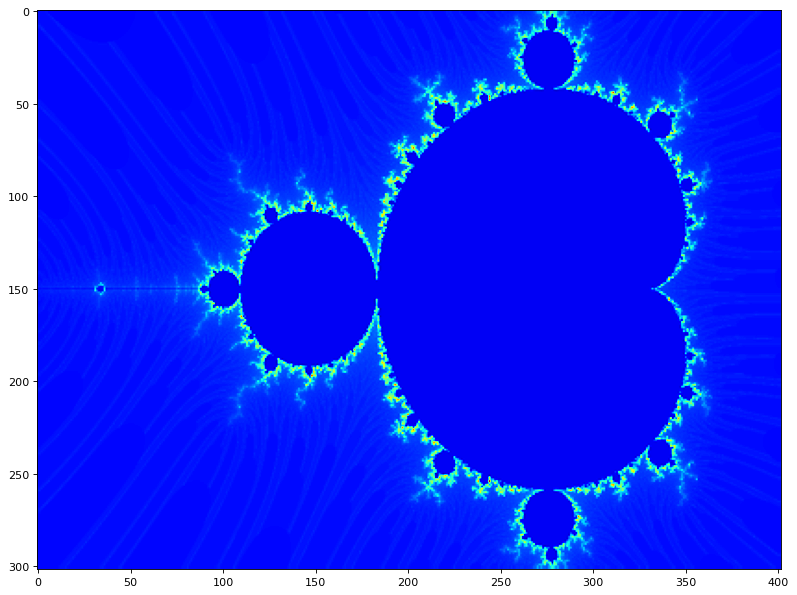

In [9]:
fig = plt.figure(figsize=(12, 12), dpi=80)
plt.imshow(LL, cmap=plt.cm.jet)

fig.savefig('wavelet.png', dpi=300)

In [10]:
# create small window 
window_size = (6,8) #(240,320) / (6,8) = (40,40)

In [11]:
x_step = 3
y_step = 4

idx_x = 0
idx_y = 0

# create a heatmap
#heatmap = np.array(shape=())

patchies = []

rows_per_column = []
rows = 0
column = 0

while(True):
    # when the bottem end is reached, start from the top with a y-step.  
    if idx_x + window_size[0] > HH.shape[0]:
        idx_x = 0
        idx_y += y_step
        
        rows_per_column.append(rows)
        column += 1
        rows = 0

        # print(f'idx_y + window_size[1]: {idx_y + window_size[1]}, HH_gray_abs.shape[1]: {HH_gray_abs.shape[1]}')
        if (idx_y + window_size[1] > HH.shape[1]):                 
            #patchies.append(HH_gray_abs[idx_x: idx_x + window_size[0], idx_y: idx_y + window_size[1]])
            print(f'finished after {len(patchies)} patchies')
            #print(f'{idx_x}:{idx_x + window_size[0]},{idx_y}:{idx_y + window_size[1]}')
            break


        
    #print(f'{idx_x}:{idx_x + window_size[0]},{idx_y}:{idx_y + window_size[1]}')
        
    patchies.append(HH[idx_x: idx_x + window_size[0], idx_y: idx_y + window_size[1]])
    
    idx_x += x_step   
    rows += 1

finished after 9801 patchies


In [12]:
size_x = int(1 / x_step * (HH.shape[0] - window_size[0]) + 1)
size_y = int(1 / y_step * (HH.shape[1] - window_size[1]) + 1)

size_x, size_y

(99, 99)

In [13]:
heatmap = np.ones(len(patchies))
for i in range(heatmap.shape[0]):
    heatmap[i] = patchies[i].mean()
    #print(f'mean: {patchies[i].mean()}, heatmap: {heatmap[i]}')
    
heatmap = np.abs(heatmap).reshape(size_x, size_y).T

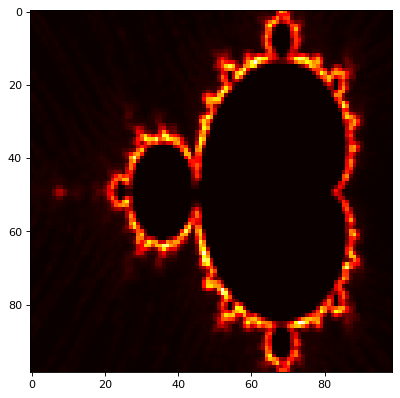

In [14]:
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(heatmap, cmap=plt.cm.hot)

fig.savefig('patchies.png', dpi=300)

In [15]:
img_array.shape

(600, 800, 3)

In [16]:
width = img_array.shape[1]
height = img_array.shape[0]

heatmap_resized = np.abs(cv2.resize(heatmap, (width, height), interpolation=cv2.INTER_CUBIC))
heatmap_resized = heatmap_resized.astype(np.uint8)
heatmap_resized.shape, np.max(heatmap_resized)

((600, 800), 30)

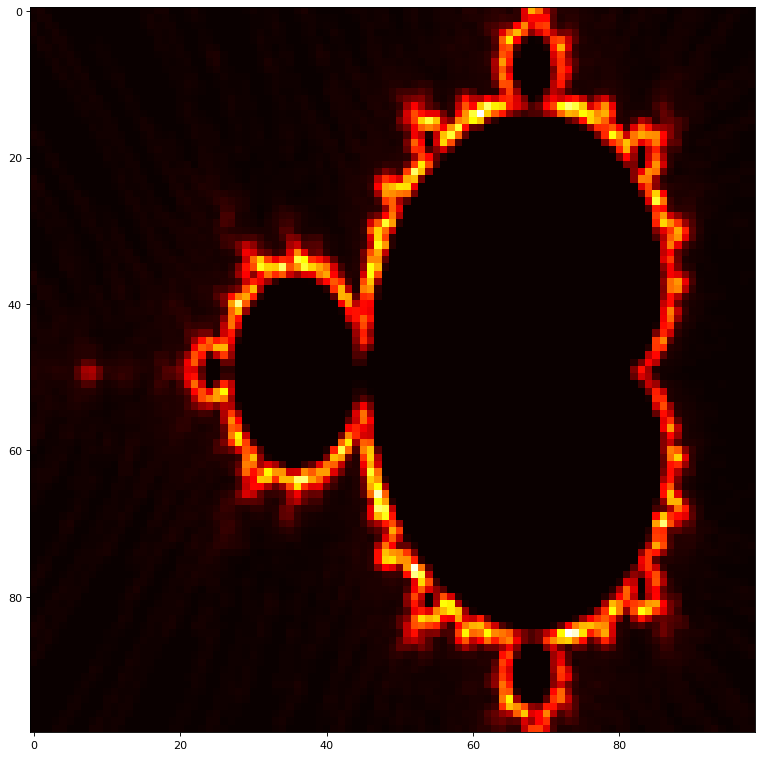

In [17]:
fig = plt.figure(figsize=(12, 12), dpi=80)
plt.imshow(heatmap, cmap=plt.cm.hot)

fig.savefig('patchies.png', dpi=300)

In [18]:
cmap = plt.get_cmap('jet')


heatmap_rescaled = np.interp(heatmap_resized, (heatmap_resized.min(), heatmap_resized.max()), (0, 255)).astype(np.uint8)

rgba_img = cmap(heatmap_rescaled)[:,:,:3]
rgba_img = rgba_img * 255.
rgba_img = rgba_img.astype(np.uint8)
rgba_img.dtype, rgba_img.shape

(dtype('uint8'), (600, 800, 3))

In [19]:
np.unravel_index(heatmap_resized.argmax(), heatmap_resized.shape)

(464, 424)

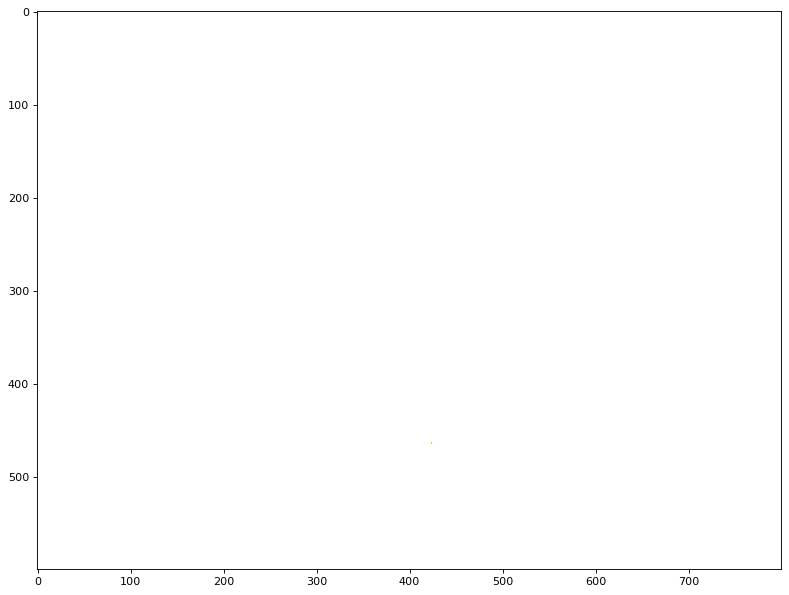

In [20]:
mask = np.ones_like(heatmap_resized)
mask[464, 424] = 0

fig = plt.figure(figsize=(12, 12), dpi=80)
plt.imshow(mask, cmap=plt.cm.hot)

In [21]:
dim0, dim1 = np.unravel_index(heatmap_resized.argmax(), heatmap_resized.shape)

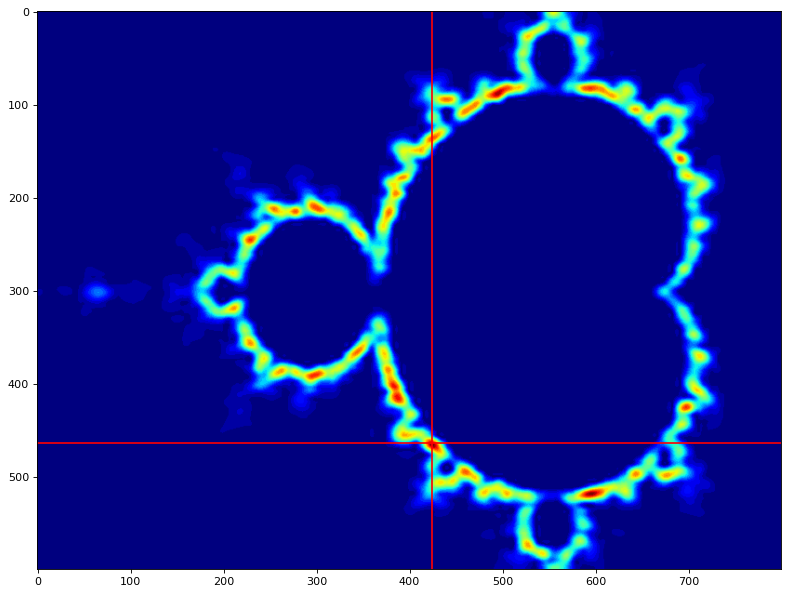

In [22]:
fig = plt.figure(figsize=(12, 12), dpi=80)
plt.imshow(rgba_img)
plt.axhline(y=dim0, color='r', linestyle='-')
plt.axvline(x=dim1, color='r', linestyle='-')


In [23]:
# compute center of highest mean
np.unravel_index(rgba_img.argmax(), rgba_img.shape)

(0, 541, 2)

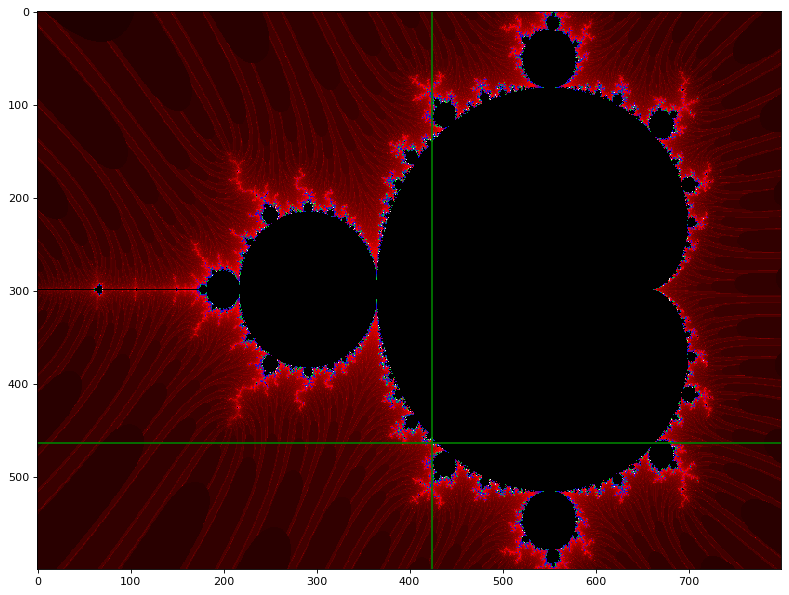

In [24]:
fig = plt.figure(figsize=(12, 12), dpi=80)
plt.imshow(img_array, interpolation='nearest')
plt.axhline(y=dim0, color='green', linestyle='-')
plt.axvline(x=dim1, color='g', linestyle='-')

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 6)
        self.conv2 = nn.Conv2d(32, 32, 6)
        self.conv3 = nn.Conv2d(32, 64, 4, 2)
        self.conv4 = nn.Conv2d(64, 128, 4, 2)
        self.dropout1 = nn.Dropout2d(0.3)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(11264, 6048) # nn.Linear(6272, 2048)
        self.fc2 = nn.Linear(6048, 2096)
        self.fc3 = nn.Linear(2096, 1024)
        self.fc3 = nn.Linear(1024, 128)
        self.fc4 = nn.Linear(128, 2)
        

    def forward(self, x):
        
        x = self.conv1(x)
        #print(x.size())
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 4)
        #x = self.dropout1(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 4)
        #x = self.dropout1(x)
        
        #return x
        

        x = torch.flatten(x, 1)
        
        print(f' SHAPE: {x.shape}')
        #return x
        
        x = self.fc1(x)
        
        return 0
        x = F.relu(x)
        #x = self.dropout2(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        #x = self.dropout2(x)
        
        x = self.fc3(x)
        x = F.relu(x)
        #x = self.dropout2(x)  
        
        x = self.fc4(x)
        
        #print(x.size())
        output = F.log_softmax(x,dim=-1)
        return output

In [27]:
model = Net()

 SHAPE: torch.Size([1, 11264])


0

ValueError: At least one stride in the given numpy array is negative, and tensors with negative strides are not currently supported. (You can probably work around this by making a copy of your array  with array.copy().) 

<Figure size 960x960 with 0 Axes>

In [119]:
img_pil = Image.open(glob.glob(f'{os.getcwd()}/data/run1/00001.bmp')[0])

trans = transforms.ToTensor()
trans1 = transforms.ToPILImage()

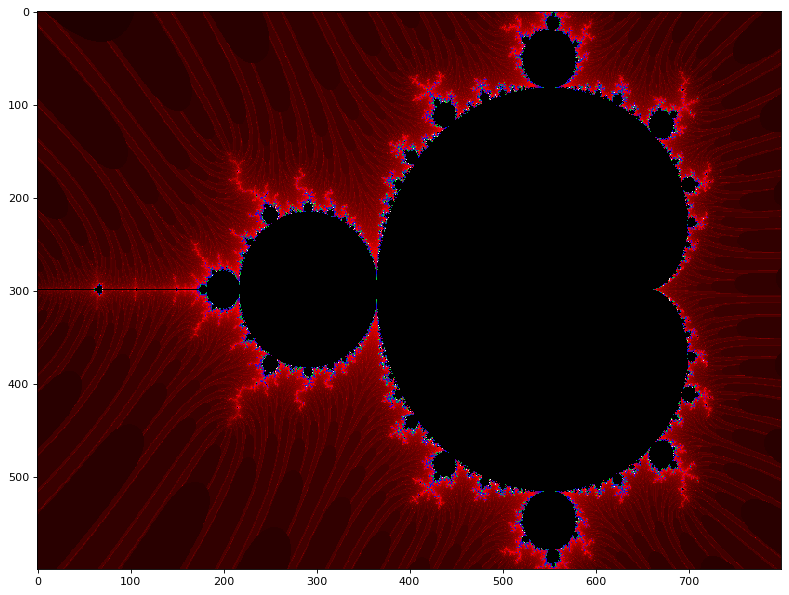

In [120]:
fig = plt.figure(figsize=(12, 12), dpi=80)
plt.imshow(trans1(trans(img_pil)), interpolation='nearest')

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [32, 3, 6, 6], but got 3-dimensional input of size [3, 600, 800] instead

In [130]:
model(trans(img_pil).unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x11264 and 6272x2048)